\begin{align*}
    \epsilon \Delta u + (u^3-u)&= f &&\text{ in } \Omega, \\
    n \cdot \nabla u &= 0 &&\text{ on } \partial \Omega.
\end{align*}
Allen-Cahn equation

In [1]:
import os, sys
sys.path.append(os.getcwd())

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import math


os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
save_path = "/localdata/tomfre/AllenCahn_data2"
input_x = torch.load(f"{save_path}/input_x.pt")
input_f = torch.load(f"{save_path}/input_data.pt")
output_u = torch.load(f"{save_path}/output_data.pt")

print("Available data points:", len(input_f))
print("Shape of data:", input_f.shape)

Available data points: 20000
Shape of data: torch.Size([20000, 64, 64, 1])


In [4]:
f_mean = torch.mean(input_f, dim=0)
u_mean = torch.mean(output_u, dim=0)

f_std = torch.std(input_f, dim=0)
u_std = torch.std(output_u, dim=0)

output_u = (output_u - u_mean) / u_std
input_f = (input_f - f_mean) / f_std

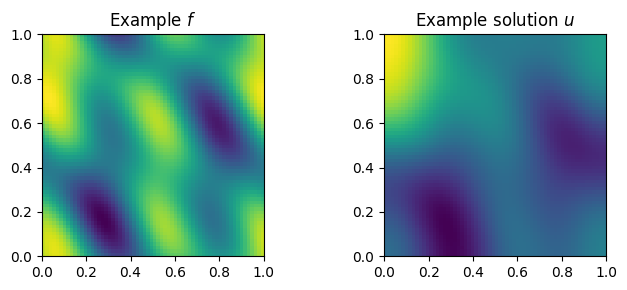

In [5]:
# Plot one example of the data
plot_idx = 456

f, axarr = plt.subplots(1, 2, figsize=(7, 3))
axarr[0].imshow(input_f[plot_idx, :, :], origin='lower', extent=[0,1,0,1])
axarr[0].title.set_text(r"Example $f$")
axarr[1].imshow(output_u[plot_idx, :, :], origin='lower', extent=[0,1,0,1])
axarr[1].title.set_text(r"Example solution $u$")
plt.tight_layout()

In [6]:
X = tp.spaces.R2("x")
F = tp.spaces.R1("f")
U = tp.spaces.R1("u")

fn_space_F = tp.spaces.FunctionSpace(X, F)
fn_space_U = tp.spaces.FunctionSpace(X, U)

In [7]:
# Split data into training and testing:
total_data = len(input_f)
train_N = int(0.9*total_data)

train_f = input_f[:train_N]
train_u = output_u[:train_N]

test_f = input_f[train_N:]
test_u = output_u[train_N:]

# Define FunctionSet (DataSet)
data_functionset_input = tp.domains.DataFunctionSet(fn_space_F, train_f)
data_functionset_output = tp.domains.DataFunctionSet(fn_space_U, train_u)

In [8]:
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(3000, data_functionset_input)
functionsampler_output = tp.samplers.FunctionSamplerCoupled(data_functionset_output, functionsampler_input)

In [9]:
### DeepONet
osci = 2
X_new = tp.spaces.Rn("x", 4*osci+2)
default_in = torch.zeros((len(input_x), 64, 64, 4*osci+2))
default_in[..., :2]= input_x
for i in range(1, osci+1):
    default_in[..., 2*i:2*i+1] = torch.cos(2*math.pi*i*input_x[..., :1]) 
    default_in[..., 2*i+1:2*i+2] = torch.sin(2*math.pi*i*input_x[..., :1]) 
    default_in[..., 2*i+2:2*i+3] = torch.cos(2*math.pi*i*input_x[..., 1:]) 
    default_in[..., 2*i+3:2*i+4] = torch.sin(2*math.pi*i*input_x[..., 1:]) 


trunk_net = tp.models.FCTrunkNet(X_new, default_trunk_input=default_in, hidden=(50, 50, 50)) 
                                #  activations=[
                                #      tp.models.AdaptiveActivationFunction(torch.nn.Tanh()),
                                #      tp.models.AdaptiveActivationFunction(torch.nn.Tanh()),
                                #      tp.models.AdaptiveActivationFunction(torch.nn.Tanh()),
                                #      tp.models.AdaptiveActivationFunction(torch.nn.Tanh())
                                #      ]
                                # )

conv_network = torch.nn.Sequential(
    torch.nn.Conv2d(1, 64, kernel_size=3),
    torch.nn.Tanh(),
    torch.nn.MaxPool2d(3),
    torch.nn.Conv2d(64, 64, kernel_size=3),
    torch.nn.Tanh(),
    torch.nn.MaxPool2d(3),
)

branch_net = tp.models.ConvBranchNet(fn_space_F, 
                                     convolutional_network=conv_network,
                                     hidden=(100, 100), grid=input_x)

model = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons=100)

# data_functionset_input.compute_pca(components=100)
# data_functionset_output.compute_pca(components=100)

# model = tp.models.PCANN_FC.from_fn_set(
#     data_functionset_input, data_functionset_output, hidden=(100, 100, 100)
# )

/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
data_condition = tp.conditions.OperatorCondition(module=model, 
                                                 input_function_sampler=functionsampler_input, 
                                                 output_function_sampler=functionsampler_output)

In [11]:
# eps = 0.0025
# step_size = (input_x[0, 0, 1, 0] - input_x[0, 0, 0, 0]).item()

# def pde_residual(u, f):
#     return eps*tp.utils.discrete_laplacian_on_grid(u, step_size) + (u**3-u) - f

# data_condition2 = tp.conditions.OperatorCondition(module=model, 
#                                                  input_function_sampler=functionsampler_input, 
#                                                  output_function_sampler=functionsampler_output, 
#                                                  residual_fn=pde_residual)

In [12]:
lr_scheduler = torch.optim.lr_scheduler.StepLR

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.005,
                            scheduler_class=lr_scheduler, 
                            scheduler_args={"step_size": 3000, "gamma":0.2})
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=15000, 
                    logger=False, 
                    enable_checkpointing=False)

trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:256: Found unsupported keys in the lr scheduler dict: {'gamma', 'step_size'}. HINT: remove them from the output of `configure_optimizers`.
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number 

Epoch 0: 100%|██████████| 15000/15000 [28:24<00:00,  8.80it/s, train/loss=0.301]

`Trainer.fit` stopped: `max_steps=15000` reached.


Epoch 0: 100%|██████████| 15000/15000 [28:24<00:00,  8.80it/s, train/loss=0.301]


In [13]:
model.cpu()
model_output = model(branch_inputs=tp.spaces.Points(test_f, F)).as_tensor.detach()
rel_error = torch.norm(model_output - test_u, p=2, dim=(1,2,3))
rel_error /= torch.norm(test_u, p=2, dim=(1,2,3))

print(torch.argmax(rel_error))
rel_error = torch.mean(torch.sqrt(rel_error))

print(f"Relative error on test data: {rel_error*100} %")

tensor(817)
Relative error on test data: 95.13289642333984 %


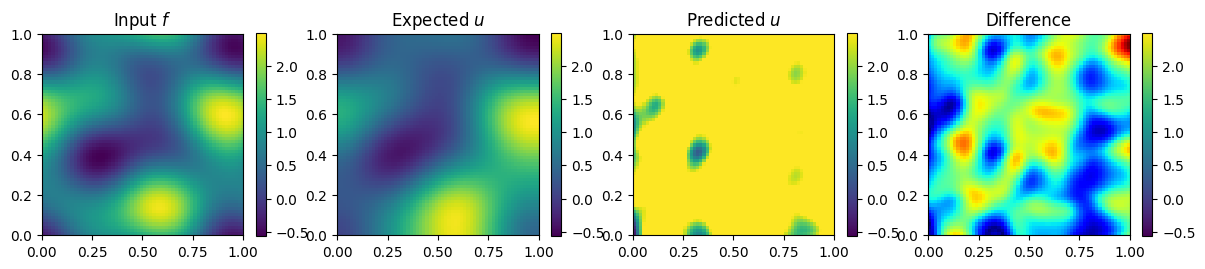

In [15]:
# Plot one example of the test data
plot_idx = 0

f, axarr = plt.subplots(1, 4, figsize=(12, 3))

vmin, vmax = torch.min(test_u[plot_idx]), torch.max(test_u[plot_idx])

img = axarr[0].imshow(test_f[plot_idx, :, :], origin='lower', extent=[0,1,0,1])
axarr[0].title.set_text(r"Input $f$")
plt.colorbar(img, ax=axarr[0], shrink=0.75)

axarr[1].imshow(test_u[plot_idx, :, :], vmin=vmin, vmax=vmax, origin='lower', extent=[0,1,0,1])
axarr[1].title.set_text(r"Expected $u$")
plt.colorbar(img, ax=axarr[1], shrink=0.75)

axarr[2].imshow(model_output[plot_idx, :, :], vmin=vmin, vmax=vmax, origin='lower', extent=[0,1,0,1])
axarr[2].title.set_text(r"Predicted $u$")
plt.colorbar(img, ax=axarr[2], shrink=0.75)

axarr[3].imshow(torch.abs(model_output[plot_idx, :, :]-test_u[plot_idx, :, :]), 
                cmap="jet", origin='lower', extent=[0,1,0,1])

axarr[3].title.set_text(r"Difference")
plt.colorbar(img, ax=axarr[3], shrink=0.75)

plt.tight_layout()